# Data Analysis and Mining 2018/ 2019

## Fuzzy Clustering with Anomalous Patterns


__Mitchell Galvao & Urszula Walińska__

__Fuzzy c-means (FCM) program in the scikit-fuzzy software package__<br>
First, we have applied the program only to 2 selected features (Average Feedback on Resorts and Museums) from your dataset. We did it for several different values of parameter c (2, ..., 10) and visualised our results on the plots below.


In [10]:
import numpy as np

In [11]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[1, 2],
           [3, 4],
           [6, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

In [12]:
from numpy import genfromtxt
data = genfromtxt('tripadvisor_review.csv', delimiter=',')
data = data[1:, 1:]

x = data[:,5] # Resorts
y = data[:,4] # Museums

alldata = np.vstack((x, y))

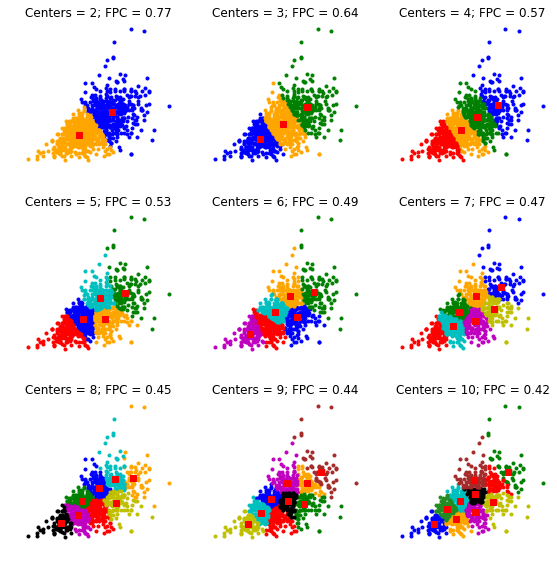

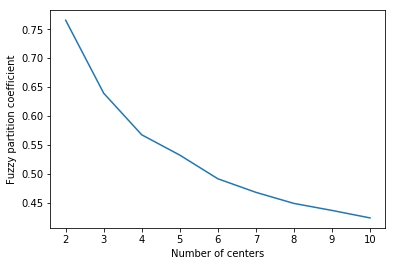

In [26]:
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2 , error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(x[cluster_membership == j],
                y[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient");

As we can see by the plots and by the graph, the more centers we have in the algorithm the worse our Fuzzy Partition Coefficient gets, until it starts converging to a limit that it wont change more. So for our scenario the number of the C parameter that would give us the best result would be 2.

High value of Partition Coefficient (Vpc) implies better performance since it is calculated on the basis of
membership values and high membership value for a single cluster implies better clustering.

__Implementation of the Anomalous Pattern (AP) clustering algorithm__

In [31]:
def center(X, cluster):
    nn, mm = X.shape
    ccc = []
    for jj in range(mm):
        zz = np.array(X[:, jj])
        zc = zz[cluster]
        ccc.append(np.mean(zc))
    
    return np.array(ccc)

In [32]:
def dist(X, remains, range_in, a):
    nn, mm = X.shape
    rr = len(remains)
    distan = np.zeros(rr)
    
    for jj in range(mm):
        z = X[:, jj]
        zz = z[remains]
        y = zz - a[jj]
        y = y / range_in[jj]
        yy = np.multiply(y, y)
        distan += yy
        
    return distan

In [33]:
def distm(X, remains, range_in, a):
    nn, mm = X.shape
    rr = len(remains)
    z = X[remains, :]
    az = np.tile(a, (rr, 1))
    rz = np.tile(range_in, (rr, 1))
    dz = np.divide(z - az, rz)
    ddz = np.multiply(dz, dz)
    
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    
    return np.array(di.T)

In [34]:
def separc(X0, remains, range_in, a, b):
    dista = distm(X0, remains, range_in, a)
    distb = distm(X0, remains, range_in, b)
    clus = dista < distb
    cluster = remains[clus]
    return cluster

In [35]:
def stand(X):
    nn, mm = X.shape
    
    print('Hit 1 for NO normalization or just "enter"')
    sst = input()
    
    me = []
    mmax = []
    mmin = []
    range_in = []
    
    for jj in range(mm):
        z = X[:, jj]
        me.append(np.mean(z))
        mmax.append(np.max(z))
        mmin.append(np.min(z))
        
        if sst == "1":
            range_in.append(1)
        else:
            range_in.append(mmax[jj] - mmin[jj])
        
        if range_in[jj] == 0:
            print('Variable number' + str(jj) + '  is constant!')
            range_in[jj] = 1
    
    return me, range_in, mmin, mmax, sst

In [36]:
def anpat(X, remains, range_in, centroid, me):
    count = 0
    key = 1
    
    while key == 1:
        cluster = separc(X, remains, range_in, centroid, me)
        if len(cluster) != 0:
            newcenter = center(X, cluster)
        else:
            newcenter = centroid
        if not np.array_equal(centroid, newcenter):
            centroid = newcenter
        else:
            key = 0
    
    return cluster, centroid

In [37]:
def anomalous(X, me, range_in, D):
    nn, mm = X.shape
    remains = np.array([*range(nn)])
    number = -1
    ancl = dict()
    
    while len(remains) > 0:
        distance = dist(X, remains, range_in, me)
        
        ind = np.argmax(distance)
        index = remains[ind]
        centroid = X[index, :]
        
        number += 1
        cluster, centroid = anpat(X, remains, range_in, centroid, me)
        ancl[(number, 1)] = cluster
        
        censtand = np.divide(centroid - me, range_in)
        dD = censtand * censtand.T * len(cluster) * 100 / D
        ancl[(number, 2)] = censtand
        ancl[(number, 3)] = dD
        remains = np.array(list(set(remains) - set(cluster)))
    
    return ancl

In [38]:
def ceupdate(X, labelc):
    K = max(labelc)
    centres = []
    
    for kk in range(K + 1):
        clk = np.where(labelc == kk)[0]
        
        nc = len(clk)
        elemk = X[clk, :]

        if nc == 0:
            print('At index ' + str(kk) + 'cluster is empty ')
        elif nc == 1:
            centres.append(elemk)
        else:
            centres.append(np.mean(elemk, axis=0))
         
    centres = np.array(centres)
    return centres

In [39]:
def clusterupdate(Y, cent):
    K, m = cent.shape
    N, m = Y.shape
    disto = []
    
    for k in range(K):
        cc = cent[k, :]
        Ck = np.tile(cc, (N, 1))
        dif = Y - Ck
        
        ddif = np.multiply(dif, dif)
        disto.append(np.array(np.sum(ddif, axis=1)))
        
    aa = np.amin(disto, axis=0)
    bb = np.argmin(disto, axis=0)
    
    wc = sum(aa)
    labelc = bb
    
    return labelc, wc

In [40]:
def k_means(Y, cent, range_in, me):
    N, m = Y.shape
    K, m1 = cent.shape
    flag = 0
    membership = np.zeros((N, 1))
    clusters = dict()
    
    dd = sum(sum(np.multiply(Y, Y)))
    
    while flag == 0:
        labelc, wc = clusterupdate(Y, cent)
        
        if np.array_equal(labelc, membership):
            flag = 1
            centre = cent
            w = wc
        else:
            cent = ceupdate(Y, labelc)
            membership = labelc
    
    centrestand = centre
    centrereal = []
    
    for ii in range(K):
        centrereal.append(np.multiply(centre[ii, :], range_in) + me)
    
    wd = w * 100 / dd
    clusters[1] = membership
    clusters[2] = centrestand
    clusters[3] = centrereal
    
    return clusters, wd

In [65]:
def ikmeansb(X, yvar):
    nn, mm = X.shape
    me, range_in, mmin, mmax, sst = stand(X)
    
    sY = (X - me) / range_in
    D = sum(sum(np.multiply(sY, sY)))
    ancl = anomalous(X, me, range_in, D)
    
    print('Input cluster cardinality to discard ')
    threshold = int(input())
    
    b = 3
    aK = int(len(ancl) / b)
    ll = []
    
    for ik in range(aK):
        ll.append(len(ancl[(ik, 1)]))
        
    ll = np.array(ll)
    rl = np.where(ll > threshold)[0]

    cent = []
    
    if len(rl) == 0:
        print('Too great threshold!!!')
    else:
        for ik in range(len(rl)):
            cent.append(ancl[(rl[ik], 2)])
    
    cent = np.array(cent)
    clusters, wd = k_means(sY, cent, range_in, me)
    return clusters, wd, cent

__Testing our implementation with the iris benchmark data set__

In [71]:
from sklearn.datasets import load_iris

data_in = load_iris()
x_values = data_in.data
clusters, wd, _ = ikmeansb(x_values, [])
print("Clusters:", clusters)
print("wd:", wd)

Hit 1 for NO normalization or just "enter"
1
Input cluster cardinality to discard 
10
Clusters: {1: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int64), 2: array([[ 1.01051282,  0.01958974,  1.95738462,  0.85451282],
       [-0.83733333,  0.37066667, -2.296     , -0.95333333],
       [ 0.04027322, -0.31634973,  0.63052459,  0.2350929 ]]), 3: [array([6.85384615, 3.07692308, 5.71538462, 2.05384615]), array([5.006, 3.428, 1.462, 0.246]), array([5.88360656, 2.74098361, 4.38852459, 1.43442623])]}
wd: 11.57309485116869


In [72]:
def report(clusters):
    n = max(clusters[1])
    
    for i in range(n + 1):
        print("Cluster", i+1, "(" + str(sum(clusters[1] == i)) + ")")
        print(np.where(clusters[1] == i)[0])
        print("Cluster centroid (real)", clusters[3][i])
        print("Cluster centroid (stand)", clusters[2][i], "\n")

report(clusters)

Cluster 1 (39)
[ 50  52  77 100 102 103 104 105 107 108 109 110 111 112 115 116 117 118
 120 122 124 125 128 129 130 131 132 134 135 136 137 139 140 141 143 144
 145 147 148]
Cluster centroid (real) [6.85384615 3.07692308 5.71538462 2.05384615]
Cluster centroid (stand) [1.01051282 0.01958974 1.95738462 0.85451282] 

Cluster 2 (50)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Cluster centroid (real) [5.006 3.428 1.462 0.246]
Cluster centroid (stand) [-0.83733333  0.37066667 -2.296      -0.95333333] 

Cluster 3 (61)
[ 51  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 101 106 113 114 119 121 123
 126 127 133 138 142 146 149]
Cluster centroid (real) [5.88360656 2.74098361 4.38852459 1.43442623]
Cluster centroid (stand) [ 0.04027322 -0.31634973  0

As we can see, we have obtained similar and satisfying results for the iris data set without normalization and with cluster cardinality to discard equal 10.

__Using Anomalous Clustering as the initialization algorithm to the fuzzy c-means and applying the
AnomalousPatterns_FCM to our data set__<br>

Based on the Anomalous Pattern algorithm we want to find the anomalous clusters in ou dataset. So we have to preprocess the data by centering to a Reference point, typically grand mean. 0 is grand mean since that.

How to Build Anomalous cluster:
1. Initial center c is entity, farthest away from 0.
2. Cluster update: if d(yi,c) < d(yi,0), assign yi to S.
3. Centroid update: Within-S mean, c’.
4. Stop condition: If c' != c, Go to step 2. with c c’;
<br>
Otherwise, halt.

The local of the initial prototypes will be defined as the centroids farthest away from the center, and as we iterate on the algorithm the centroids will be updated until we meet the stop condition or apply threshold on the minimum cardinality of the cluster that we choose.

First, we have applied k-means algorithm with Anomalous Pattern initialization (without normalization and with cluster cardinality to discard equal 10) to our data and we have got results presented below. This way we have also obtained the initial fuzzy c-partitioned matrix that we will use in fuzzy c-means method.

In [80]:
data = genfromtxt('tripadvisor_review.csv', delimiter=',')
data = data[1:, 1:-1]
clusters, wd, cent = ikmeansb(data, [])
print("Clusters:", clusters)
print("wd:", wd)

Hit 1 for NO normalization or just "enter"
1
Input cluster cardinality to discard 
10
Clusters: {1: array([1, 8, 6, 7, 5, 2, 2, 2, 5, 3, 5, 7, 1, 1, 1, 8, 4, 1, 5, 1, 5, 3,
       2, 2, 5, 8, 1, 4, 2, 1, 1, 8, 8, 3, 2, 4, 4, 2, 1, 6, 3, 2, 3, 7,
       7, 6, 2, 4, 7, 1, 3, 1, 3, 4, 2, 2, 1, 2, 1, 5, 1, 6, 2, 2, 6, 6,
       4, 2, 4, 2, 6, 1, 7, 1, 4, 8, 6, 1, 2, 3, 6, 4, 2, 6, 6, 7, 2, 2,
       0, 7, 6, 2, 8, 1, 8, 6, 1, 4, 1, 3, 3, 2, 8, 2, 6, 1, 5, 2, 6, 8,
       7, 4, 7, 4, 1, 3, 4, 3, 4, 4, 8, 3, 8, 6, 5, 2, 2, 4, 4, 2, 4, 5,
       8, 5, 7, 3, 4, 5, 3, 2, 3, 2, 7, 2, 3, 7, 3, 1, 5, 5, 5, 7, 2, 7,
       7, 4, 3, 6, 8, 4, 4, 2, 7, 4, 4, 2, 1, 3, 1, 4, 3, 6, 2, 2, 3, 7,
       3, 4, 3, 2, 2, 5, 5, 4, 1, 3, 3, 6, 5, 2, 1, 1, 6, 3, 3, 2, 4, 5,
       4, 0, 1, 7, 1, 2, 4, 2, 3, 2, 4, 4, 4, 1, 7, 2, 2, 5, 2, 2, 5, 1,
       3, 4, 8, 2, 5, 7, 0, 4, 7, 1, 2, 1, 2, 7, 3, 3, 5, 7, 5, 6, 1, 8,
       4, 7, 2, 4, 6, 0, 6, 3, 5, 2, 1, 1, 7, 7, 2, 0, 6, 5, 5, 5, 6, 8,
       2, 5, 1, 7, 7, 5,

In [81]:
report(clusters)

Cluster 1 (18)
[ 88 199 226 247 257 274 286 372 422 437 592 601 666 694 728 747 829 903]
Cluster centroid (real) [1.02888889 2.00444444 0.57666667 2.18388889 1.17333333 2.05111111
 3.18222222 2.72333333 1.46      ]
Cluster centroid (stand) [ 1.35695011e-01  6.51832200e-01 -4.36639456e-01  1.65138889e+00
  2.33598639e-01  2.08213152e-01  1.28344671e-03 -1.11727891e-01
 -1.09438776e-01] 

Cluster 2 (138)
[  0  12  13  14  17  19  26  29  30  38  49  51  56  58  60  71  73  77
  93  96  98 105 114 147 166 168 184 190 191 200 202 211 219 229 231 240
 252 253 266 272 273 282 290 301 304 307 309 316 318 326 331 341 343 348
 349 371 375 385 401 407 409 415 420 430 458 465 470 475 478 497 498 502
 510 515 517 522 524 537 551 555 560 561 562 566 567 588 598 622 640 654
 655 660 662 665 671 685 717 718 719 733 750 780 781 785 786 790 791 798
 799 802 805 807 814 816 818 819 828 834 835 857 859 860 862 866 883 885
 892 901 907 915 924 925 931 942 951 955 960 963]
Cluster centroid (real) [0.790652

With parameter c = 9 we obtain these results:

In [76]:
ncenters = 9

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, ncenters, 2, error=0.005, maxiter=7, init=cent)

print(cntr, u, u0, d, jm, p, fpc)

[[0.62       0.64       0.53       ... 0.43       0.43       0.51      ]
 [2.42       3.18       1.54       ... 1.78       0.4        2.36      ]
 [3.19       3.21       3.18       ... 3.17       3.18       3.18      ]
 ...
 [2.42       3.18       1.54       ... 1.78       0.4        2.36      ]
 [1.85111111 2.09111111 1.35111111 ... 1.49222222 1.07444444 1.58      ]
 [1.85111111 2.09111111 1.35111111 ... 1.49222222 1.07444444 1.58      ]] [[8.73027508e-31 1.86466584e-31 2.89749943e-31 1.00000000e+00
  6.26447419e-31 1.68945521e-32 4.93038066e-32 4.93038066e-32
  1.05064579e-31]
 [2.07935773e-31 2.57675031e-31 2.01834807e-31 1.72999443e-31
  2.51088817e-31 3.33333333e-01 1.68289577e-31 2.05998220e-31
  2.92212481e-31]
 [4.93038066e-32 4.93038066e-32 4.93038066e-32 4.93038066e-32
  4.93038066e-32 1.64346022e-32 1.00000000e+00 1.92145331e-30
  4.93038066e-32]
 [2.07935773e-31 2.57675031e-31 2.01834807e-31 1.72999443e-31
  2.51088817e-31 3.33333333e-01 1.68289577e-31 2.05998220e-31
  2.92

Where:
- cntr stands for cluster centers. Data for each center along each feature provided for every cluster (of the c requested clusters).
- u stands for final fuzzy c-partitioned matrix.
- u0 stands for initial guess at fuzzy c-partitioned matrix (either provided init or random guess used if init was not provided).
- d stands for final Euclidian distance matrix.
- jm stands for objective function history.
- p stands for number of iterations run.
- fpc stands for final fuzzy partition coefficient.

__Applying indices (Xie-Beni and Partition Coefficient), to access the quality of the fuzzy c-partitions__

In [117]:
import scipy.spatial

def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def xb(x, u, v, m):
    n = x.shape[0]
    c = v.shape[0]

    um = u**m
    
    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)
    
    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def fcm_get_u(x, v, m):
    distances = pairwise_squared_distances(x, v)
    nonzero_distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = np.reciprocal(nonzero_distances)**(1/(m - 1))
    return inv_distances.T/np.sum(inv_distances, axis=1)

__Comparision of the results of fuzzy c-means algorithm with Anomalous Pattern and without it__

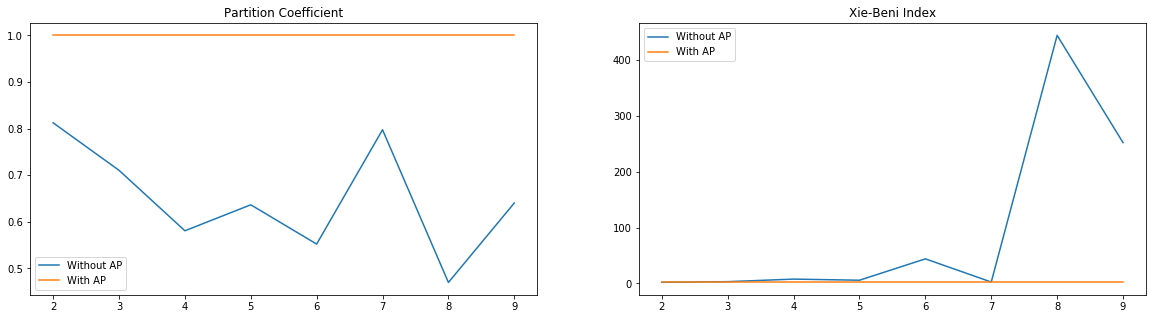

In [116]:
fpcs = [[], []]
xbs = [[], []]

for ncenters in range(2, 10):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data, ncenters, 2, error=0.005, maxiter=7, init=None)

    fpcs[0].append(fpc)
    xbs[0].append(xb(data, fcm_get_u(data, u, m), u, m))
    
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data, ncenters, 2, error=0.005, maxiter=7, init=cent)
    
    fpcs[1].append(fpc)
    xbs[1].append(xb(data, fcm_get_u(data, u, m), u, m))


plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(2, 10), fpcs[0], label='Without AP')
plt.plot(np.arange(2, 10), fpcs[1], label='With AP')
plt.title('Partition Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(2, 10), xbs[0], label='Without AP')
plt.plot(np.arange(2, 10), xbs[1], label='With AP')
plt.title('Xie-Beni Index')
plt.legend()

plt.show()

As we can see, fuzzy c-means algorithm with Anomalous Patter initialization performs almost perfectly even after 7 interations. The value of Partition Coefficient is equal 1 (which is the best possible) no matter how many clusters do we want to have. The same goes for the value of Xie-Beni Index (the lower the better) which is also satisfying regardless the number of clusters. On the other hand, we can notice that our algorithm without AP initialization performs significantly worse. In case of the value of Xie-Bani Index, we can see that the less clusters we want to have, the better are results obtained.

Another conclusion worth of being mentioned is about the number of iterations. Without AP initialization algorithm also performed well but only after high number of iterations. That is why, to be able to compare these 2 methods, in our analysis we have introduced a constraint of max iterations = 7.